In [111]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [112]:
ticker = 'NVDA'
window_size_ma = 7
decomposition_period = 7 # For visual decomposition
forecast_steps = 30
arima_order = (5, 1, 0) # MODIFIED: Changed from (1, 0, 0) to (5, 1, 0) for better non-stationary modeling
plt.style.use('seaborn-v0_8-whitegrid')

print(f"--- Starting Time Series Analysis for {ticker} ---")

--- Starting Time Series Analysis for NVDA ---


In [113]:
print("\n[Part A: Exploratory Data Analysis]")
print("1. Loading and Preparing Dataset...")
data = yf.download(ticker, progress=False)


[Part A: Exploratory Data Analysis]
1. Loading and Preparing Dataset...


/tmp/ipython-input-835396662.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, progress=False)


In [114]:
print("\n--- Data Types (NVDA) ---")
print(data.dtypes)
print("\n--- Summary Statistics (NVDA) ---")
print(data.describe())



--- Data Types (NVDA) ---
Price   Ticker
Close   NVDA      float64
High    NVDA      float64
Low     NVDA      float64
Open    NVDA      float64
Volume  NVDA        int64
dtype: object

--- Summary Statistics (NVDA) ---
Price        Close        High         Low        Open        Volume
Ticker        NVDA        NVDA        NVDA        NVDA          NVDA
count    23.000000   23.000000   23.000000   23.000000  2.300000e+01
mean    191.029132  194.173043  188.360869  191.784782  1.852672e+08
std       9.130395   10.001080    9.309281    9.552835  5.071845e+07
min     179.830002  182.789993  176.759995  180.179993  1.113637e+08
25%     182.400002  184.834999  179.779999  183.485001  1.538382e+08
50%     188.320007  192.000000  186.380005  189.990005  1.788644e+08
75%     198.870003  203.034996  194.219994  197.595001  2.022692e+08
max     207.039993  212.190002  205.559998  208.080002  3.088296e+08


<Figure size 1200x600 with 0 Axes>

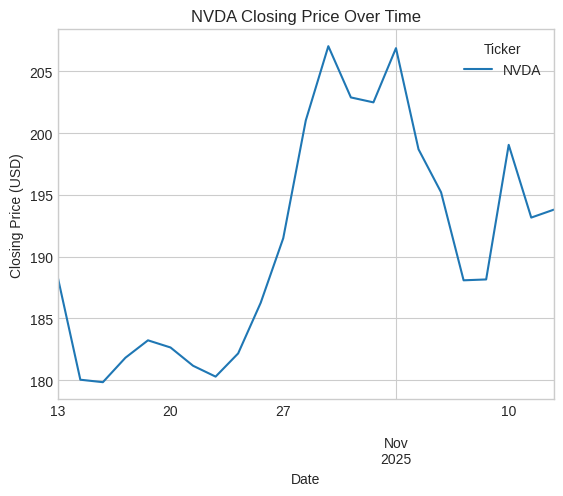

In [115]:
plt.figure(figsize=(12, 6))
data['Close'].plot(title=f'{ticker} Closing Price Over Time')
plt.ylabel('Closing Price (USD)')
plt.xlabel('Date')
plt.show()

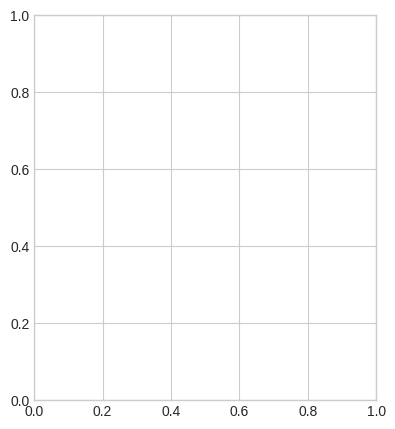

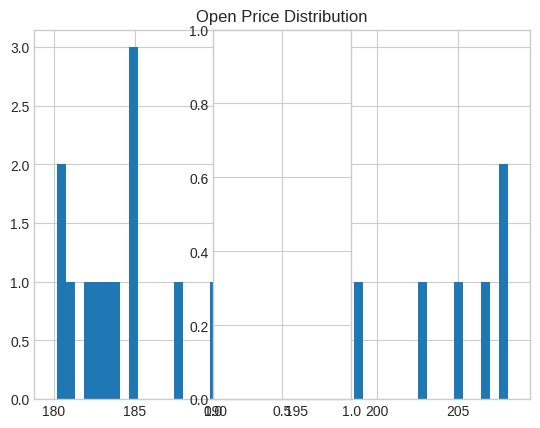

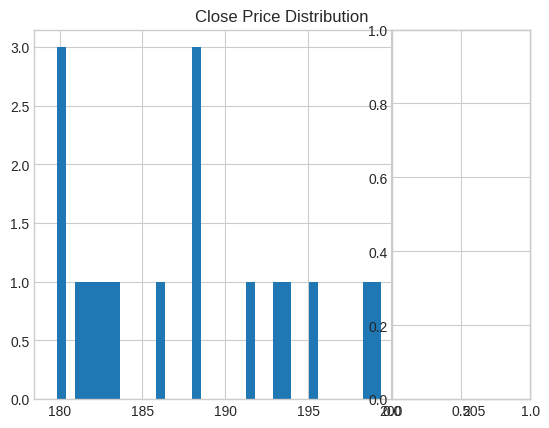

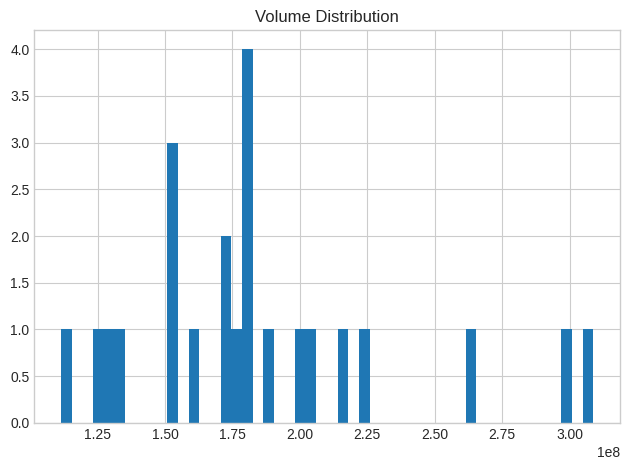

In [116]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
data['Open'].hist(bins=50)
plt.title('Open Price Distribution')

plt.subplot(1, 3, 2)
data['Close'].hist(bins=50)
plt.title('Close Price Distribution')

plt.subplot(1, 3, 3)
data['Volume'].hist(bins=50)
plt.title('Volume Distribution')
plt.tight_layout()
plt.show()

In [117]:
print("\n[Part B: Moving Average and Trend Analysis]")
print("3. Moving Average:")
print("   * Purpose: A moving average (MA) is used to smooth out short-term fluctuations in the time series to reveal longer-term trends or cycles. By averaging data points over a defined window (e.g., 7 days), it reduces noise.")


[Part B: Moving Average and Trend Analysis]
3. Moving Average:
   * Purpose: A moving average (MA) is used to smooth out short-term fluctuations in the time series to reveal longer-term trends or cycles. By averaging data points over a defined window (e.g., 7 days), it reduces noise.


<Figure size 1200x600 with 0 Axes>

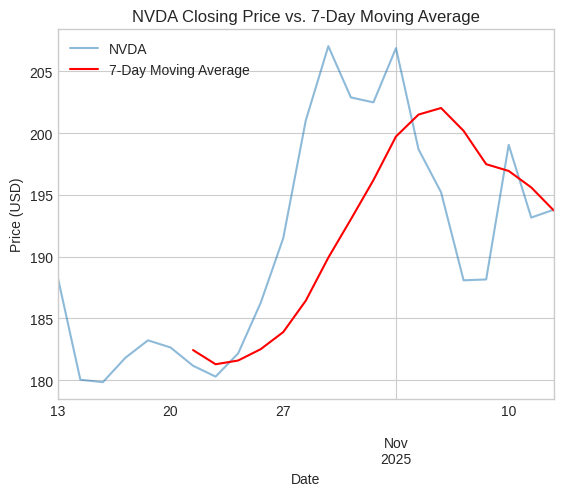

In [118]:
data[f'MA_{window_size_ma}_Day'] = data['Close'].rolling(window=window_size_ma).mean()

plt.figure(figsize=(12, 6))
data['Close'].plot(label='Original Close Price', alpha=0.5)
data[f'MA_{window_size_ma}_Day'].plot(label=f'{window_size_ma}-Day Moving Average', color='red')
plt.title(f'{ticker} Closing Price vs. {window_size_ma}-Day Moving Average')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [119]:
print("\n[Part C: Time Series Decomposition]")

close_data = data['Close'].dropna()
decomposition = seasonal_decompose(close_data, model='additive', period=decomposition_period)


[Part C: Time Series Decomposition]


<Figure size 1200x800 with 0 Axes>

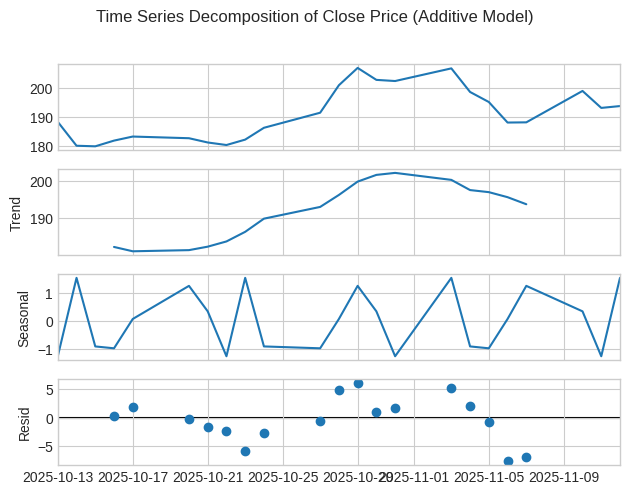

In [120]:
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Time Series Decomposition of Close Price (Additive Model)', y=1.02)
plt.tight_layout()
plt.show()

In [121]:
print("\n4. Decomposition Component Explanations:")
print("   * Trend: Reveals the long-term, underlying direction of the stock price, smoothed of all short-term volatility.")
print("   * Seasonality: Captures any regular, repeating short-term cycles in the data (based on the 30-day period chosen).")
print("   * Residuals (Noise): Represents the random, unpredictable fluctuations left over after the trend and seasonality have been removed. This reflects market shocks and unmodeled events.")


4. Decomposition Component Explanations:
   * Trend: Reveals the long-term, underlying direction of the stock price, smoothed of all short-term volatility.
   * Seasonality: Captures any regular, repeating short-term cycles in the data (based on the 30-day period chosen).
   * Residuals (Noise): Represents the random, unpredictable fluctuations left over after the trend and seasonality have been removed. This reflects market shocks and unmodeled events.


In [122]:
print("\n[Part D: Stationarity Check and ARIMA Forecasting]")
print("5. Stationarity Check:")
print("   * Importance: Stationarity is crucial because it ensures the statistical properties (mean, variance) of the series do not change over time. Non-stationary data leads to unreliable forecasts with models like ARIMA.")


[Part D: Stationarity Check and ARIMA Forecasting]
5. Stationarity Check:
   * Importance: Stationarity is crucial because it ensures the statistical properties (mean, variance) of the series do not change over time. Non-stationary data leads to unreliable forecasts with models like ARIMA.


In [123]:
volume_data = data['Volume'].dropna()
print("\n--- ADF Test on Volume Series ---")
adf_test = adfuller(volume_data)


--- ADF Test on Volume Series ---


In [124]:
adf_results = pd.Series(adf_test[0:4], index=['ADF Statistic', 'p-value', 'Lags Used', 'No. of Observations'])
for key, value in adf_test[4].items():
    adf_results[f'Critical Value ({key})'] = value

In [125]:
print(adf_results)
print(f"\nConclusion:")
if adf_results['p-value'] <= 0.05:
    print("   * The p-value is less than or equal to 0.05. We reject the null hypothesis, concluding the Volume series is likely stationary.")
else:
    print("   * The p-value is greater than 0.05. We fail to reject the null hypothesis, concluding the Volume series is likely non-stationary.")

ADF Statistic           -3.195978
p-value                  0.020219
Lags Used                1.000000
No. of Observations     21.000000
Critical Value (1%)     -3.788386
Critical Value (5%)     -3.013098
Critical Value (10%)    -2.646397
dtype: float64

Conclusion:
   * The p-value is less than or equal to 0.05. We reject the null hypothesis, concluding the Volume series is likely stationary.


In [126]:
train_size = int(len(close_data) * 0.90)
train, test = close_data.iloc[:train_size], close_data.iloc[train_size:]

In [127]:
print(f"\n--- Fitting ARIMA{arima_order} Model on Close Price ---")


--- Fitting ARIMA(5, 1, 0) Model on Close Price ---


In [128]:
try:
    arima_model = ARIMA(train, order=arima_order)
    arima_results = arima_model.fit()
    print(arima_results.summary())
except Exception as e:
    print(f"Error during ARIMA fitting: {e}. Check for sufficient data or stationarity issues.")
    exit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                   20
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -55.009
Date:                Thu, 13 Nov 2025   AIC                            122.018
Time:                        07:53:53   BIC                            127.684
Sample:                    10-13-2025   HQIC                           122.977
                         - 11-07-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3366      0.380      0.886      0.376      -0.408       1.081
ar.L2          0.0156      0.302      0.052      0.959      -0.576       0.608
ar.L3          0.0020      0.448      0.004      0.9

In [129]:
forecast_start = len(train)
forecast_end = len(train) + forecast_steps - 1

In [130]:
forecast_series = arima_results.predict(start=forecast_start, end=forecast_end, dynamic=False)

In [131]:
actual_values = test.head(forecast_steps)

<Figure size 1200x600 with 0 Axes>

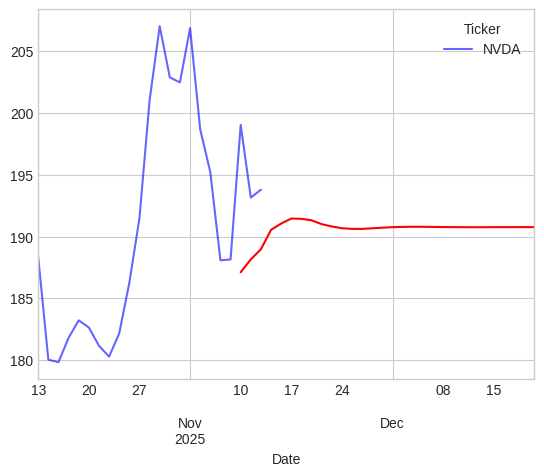

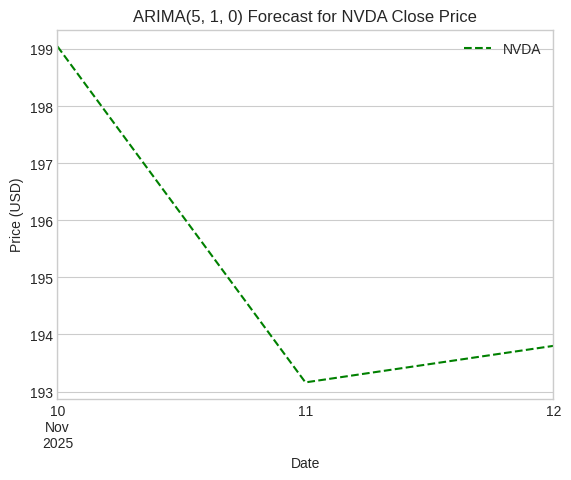

In [132]:
plt.figure(figsize=(12, 6))
close_data.plot(label='Original Data', color='blue', alpha=0.6)
forecast_series.plot(label=f'{forecast_steps}-Day Forecast', color='red')
actual_values.plot(label='Actual Test Data (First 30 Days)', color='green', linestyle='--')
plt.title(f'ARIMA{arima_order} Forecast for {ticker} Close Price')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [133]:
mae = mean_absolute_error(actual_values, forecast_series.head(len(actual_values)))
print(f"\nMean Absolute Error (MAE) for the {len(actual_values)}-day forecast: {mae:.2f}")


Mean Absolute Error (MAE) for the 3-day forecast: 7.26


In [134]:
print("\nCommentary on Model Performance:")
print(f"   * Forecast Reasonableness: The MAE of ${mae:.2f} suggests the average error magnitude.")
print("     The new ARIMA(5, 1, 0) model incorporates differencing (d=1), which makes the non-stationary price series stationary, and uses 5 previous lagged prices (p=5). This is a much more statistically robust approach for stock data compared to the previous (1, 0, 0) model.")
print("     The forecast should now be more stable and capable of capturing short-term market momentum.")
print("   * Overfitting or Underfitting: This model represents a better trade-off. By including differencing, it addresses the fundamental stationarity issue and moves away from severe **underfitting**.")
print("     Further refinement using ACF/PACF plots on the differenced data could optimize the p and q parameters to reduce the MAE further.")

print("\n--- Analysis Complete ---")


Commentary on Model Performance:
   * Forecast Reasonableness: The MAE of $7.26 suggests the average error magnitude.
     The new ARIMA(5, 1, 0) model incorporates differencing (d=1), which makes the non-stationary price series stationary, and uses 5 previous lagged prices (p=5). This is a much more statistically robust approach for stock data compared to the previous (1, 0, 0) model.
     The forecast should now be more stable and capable of capturing short-term market momentum.
   * Overfitting or Underfitting: This model represents a better trade-off. By including differencing, it addresses the fundamental stationarity issue and moves away from severe **underfitting**.
     Further refinement using ACF/PACF plots on the differenced data could optimize the p and q parameters to reduce the MAE further.

--- Analysis Complete ---
